# Topics
* [Hough Transfrom](#1)

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

import warnings
warnings.simplefilter('ignore')

In [2]:
TEST_IMAGE = 'test.jpg'
FLOWER_IMAGE = 'flower.jpeg'
LINES_IMAGE = 'images/lines.jpeg'
IMAGE_SHAPE = (350, 350)

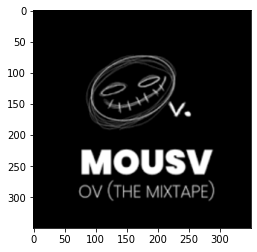

In [3]:
test_im = cv2.imread(TEST_IMAGE, cv2.IMREAD_GRAYSCALE)
test_im = cv2.resize(test_im, IMAGE_SHAPE)

plt.imshow(test_im, cmap='gist_gray')

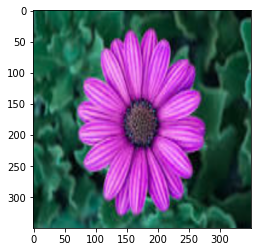

In [4]:
flower_im = cv2.imread(FLOWER_IMAGE)
flower_im = cv2.resize(flower_im, IMAGE_SHAPE)

plt.imshow(flower_im)

<a id=1></a>
## Hough Transform

**First** Hough space: it is a ${R^2}$ space of two variables m, b(where m: slope of line, b: Line intercept with y axis) in line equation:

$$y = mx + b$$

notes:
duality is acheived between (x, y) space and hough space where:
* line in orthogonal coordintes represents a point in hough space
* line in hough space represents a point in orthogonal coordinates

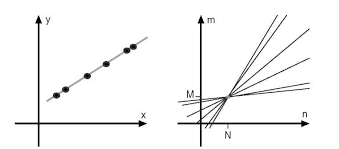
[source](http://what-when-how.com/biomedical-image-analysis/the-hough-transform-biomedical-image-analysis/)

Hough transform strategy:<br>
> we have some <font color='red'>**edge**</font> points and we need to know if they represent a line or not.

Hough transform processes:
1. we get the hough space representation (line) of each point.
2. we plot these lines in the same graph and find out where is the area that have large number of lines
3. probably the ebst fit line in orthogonal coordinates have parametes , b in that area (has most votes) in hough space

Polar hough space:
we usually use polar form to represent line instead of using orthogonal coordinates {d, $\theta$ instead of $m, b$}
so that the equation of line is:

$$d = x cos(\theta) + y sin(\theta)$$
* d: the prepindecular distance between our line and origin.
* $\theta$: angle between our line and $x$ axis.

so this will affect the hough space where lines in hough space of ($m, b$) will turn into sinusoidal waves in terms of ($d, \theta$) 
thus, point in orthogonal coordinates will be sinusoidal wave in hough space

[source_1](https://www.researchgate.net/figure/Houghs-transformation-a-Cartesian-image-space-b-polar-Hough-space-Coordinates-of_fig2_263124873)<br>
[source_2](https://www.researchgate.net/figure/The-polar-representation-of-a-line-and-its-Hough-space_fig2_272181380)


<img src='images/polar_hough.jpeg' align='left'></img>
<img src='images/hough_polar2.png' align='right'></img><br>

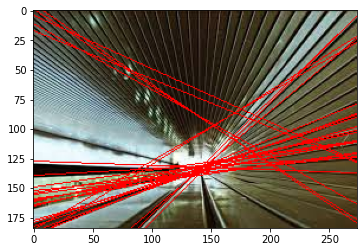

In [5]:
lines_im = cv2.imread(LINES_IMAGE)
plt.imshow(lines_im) 

lines_im_edges = cv2.Canny(lines_im, threshold1=100, threshold2=150, apertureSize=3)
plt.imshow(lines_im_edges, cmap='gist_gray')

lines = cv2.HoughLines(lines_im_edges, rho=3, theta=np.pi / 180, threshold=290)
'''
flower_im_edges: Output of the edge detector. It should be a grayscale image
rho : The resolution of the parameter r in pixels. We use 1 pixel.
theta: The resolution of the parameter θ in radians. We use 1 degree
threshold: The minimum number of intersections to "*detect*" a line

lines: A vector that will store the parameters (xstart,ystart,xend,yend) of the detected lines
'''

def plot_lines(lines, image):
    for line in lines:
        # line equation: x = r * cos(theta), y = r * sin(theta)
        r, theta = line[0]
        
        x0 = r * np.cos(theta)
        y0 = r * np.sin(theta)
        
        # find two points in this line
        pt1 = int(x0 - 1000 * (- np.sin(theta))), int(y0 - 1000 * (np.cos(theta)))
        pt2 = int(x0 + 1000 * (- np.sin(theta))), int(y0 + 1000 * (np.cos(theta)))
        
        cv2.line(image, pt1, pt2, (255, 0, 0), 1)
        
plot_lines(lines, lines_im)
plt.imshow(lines_im)

### Hough line detection from scratch

In [6]:
%%time
edges = cv2.Canny(lines_im, threshold1=200, threshold2=300)

def extract_point(edges):
    points = []
    for i in range(len(edges)):
        for j in range(edges.shape[1]):
            if edges[i, j]==255:
                points.append((i, j))
    return points

def transform_to_hough_space(x0, y0):
    theta = np.arange(0, 2 * np.pi, np.pi / 180)
    d = x0 * np.cos(theta) + y0 * np.sin(theta)
    return d

edge_points = extract_point(edges)

R = np.array([])
for point in edge_points:
    R = np.append(R, transform_to_hough_space(point[0], point[1]))

R = R.reshape(-1, 360)

CPU times: user 39.9 s, sys: 25.4 s, total: 1min 5s
Wall time: 1min 5s


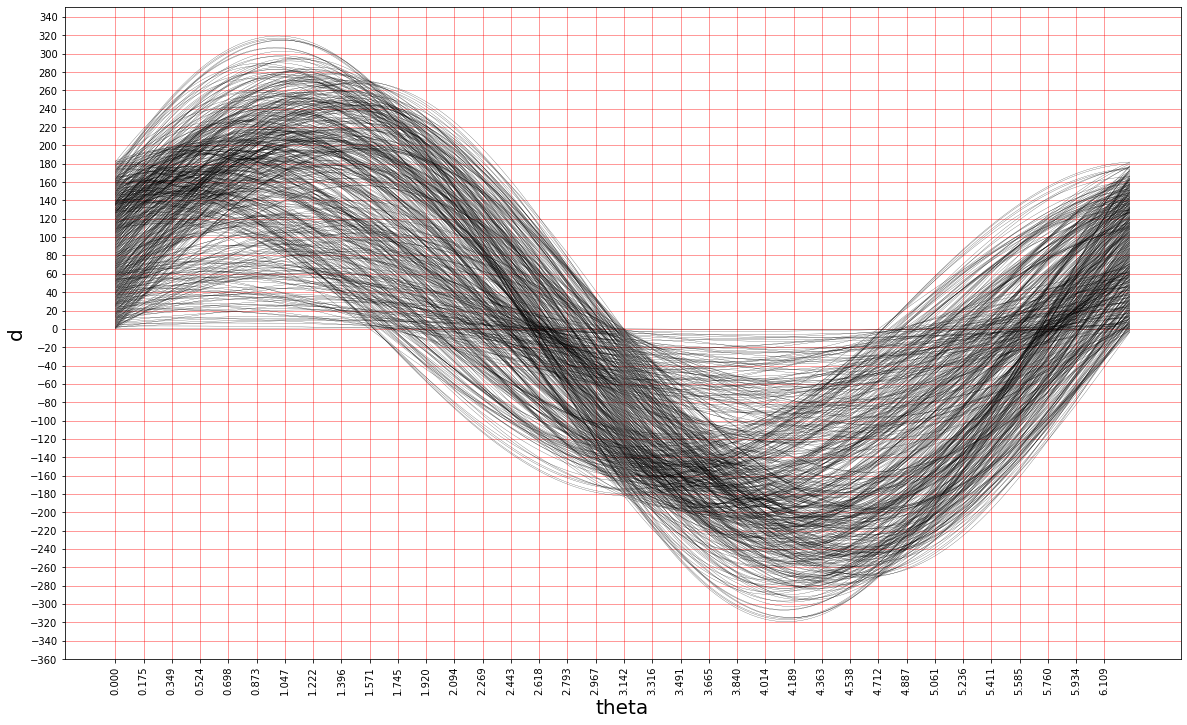

In [7]:
fig = plt.figure(figsize=(20, 12))
ax = plt.subplot(1, 1, 1)
theta = np.arange(0, 2 * np.pi, np.pi / 180)

# ax = sns.heatmap(count, xticklabels=x_grid, yticklabels=r_grid, cmap='Reds', alpha=1)

for r in R[::20]:
    ax.plot(theta, r, color='k', linewidth=0.2)
ax.set_xlabel('theta', size=20)
ax.set_ylabel('d', size=20)

ax.set_xticks(np.arange(0, 2*np.pi, 10 * np.pi / 180))
ax.set_yticks(np.arange(-360, 360, 20))
plt.xticks(rotation=90);
# sns.heatmap(count, xticklabels=x_grid, yticklabels=r_grid, cmap='rocket_r', alpha=1, ax=ax, center=True)
ax.grid(color='red', which='both', alpha=0.5)


In [8]:
x_grid = np.arange(0, 2 * np.pi, 10 * np.pi / 180)
r_grid = np.arange(-360, 360, 20)

R_cat = np.digitize(R, r_grid)

count = np.zeros((36, 36))
for i in range(len(x_grid)):
    for j in range(len(r_grid)):
        cnt = np.sum((R_cat==r_grid[j]) & (theta==x_grid[i]))
        count[i, j] = cnt

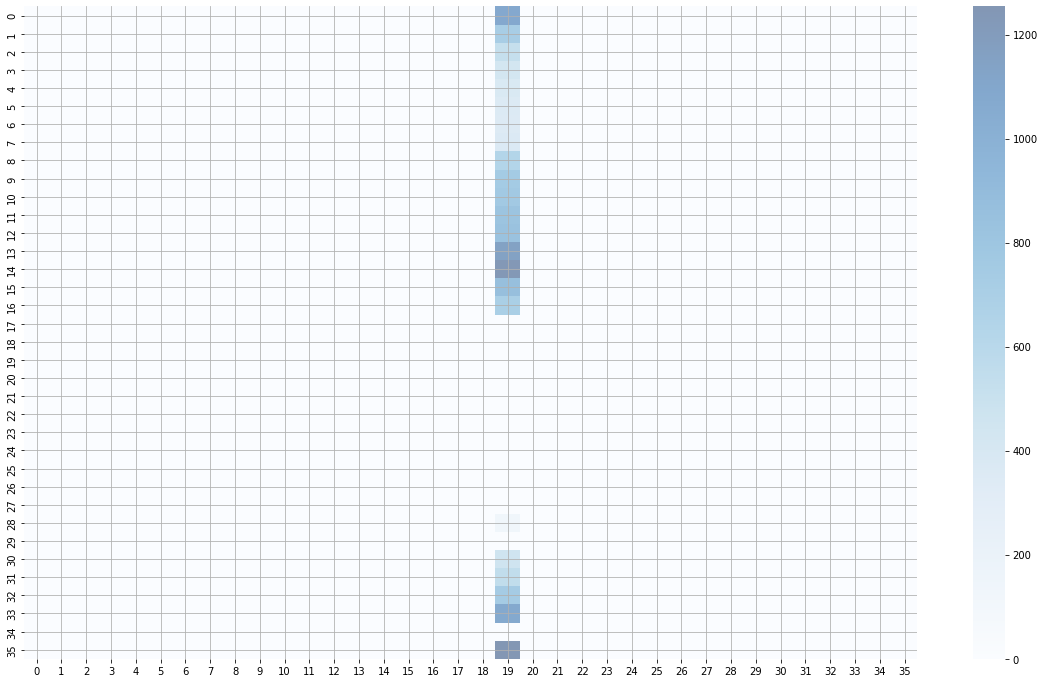

In [9]:
import seaborn as sns
plt.figure(figsize=(20, 12))
ax = plt.subplot(1, 1, 1)
ax.set_xticks(x_grid);
sns.heatmap(count, alpha=0.5, cmap='Blues', ax=ax)
plt.grid()